In [1]:
import keras
import tensorflow as tf
import gdal
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from keras_unet.models import custom_unet, satellite_unet
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from keras_unet.utils import plot_segm_history

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
base_dir = Path(r'/media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2')
mask_dir = base_dir.joinpath('masks_img')
image_dir = base_dir.joinpath('img')
water_dir = mask_dir.joinpath('water')
shrubs_dir = mask_dir.joinpath('shrub')
taiga_dir = mask_dir.joinpath('taiga')

In [3]:
def make_path(img_dir, prefix, number):
    return os.path.join(img_dir, f"{prefix}_{number}.tif")

In [4]:
def make_path_tile(img_dir, prefix, number):
    return os.path.join(img_dir, f"{prefix}{number}.tif")

In [5]:
def img_number(fpath: str) -> int:
    return int(os.path.splitext(os.path.split(fpath)[1])[0].split('_')[-1])

In [6]:
def load_image(path: str) -> np.ndarray:
    ds = gdal.Open(path, gdal.GA_ReadOnly)
    return ds.GetRasterBand(1).ReadAsArray()

In [7]:
def load_stack(shape, dtype, img_dir, prefix):
    stack = np.zeros(shape = shape, dtype = dtype)
    for i in range(shape[0]):
        image_path = make_path(img_dir, prefix, i + 1)
        stack[i, :, :] = load_image(image_path)
    return stack

def load_stack_safely(shape, dtype, img_dir, prefix):
    stack = np.zeros(shape = shape, dtype = dtype)
    for i in range(shape[0]):
        image_path = make_path(img_dir, prefix, i + 1)
        if not os.path.isfile(image_path):
            print("skipping", image_path)
            continue
        stack[i, :, :] = load_image(image_path)
    return stack

In [17]:
I = 282
N = 256
M = 256
V = 3

In [18]:
train_images = load_stack((I, N, M), np.float32, image_dir, "img")
train_images_R = train_images.reshape(I, N, M, 1)

In [19]:
train_images_R.shape

(282, 256, 256, 1)

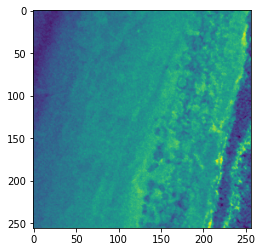

In [21]:
plt.imshow(train_images[281, :,:])

In [22]:
water_mask = load_stack_safely((I, N, M), np.int8, water_dir, "water")
taiga_mask = load_stack_safely((I, N, M), np.int8, taiga_dir, "taiga")
shrubs_mask = load_stack_safely((I, N, M), np.int8, shrubs_dir, "shrub")

skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/water/water_4.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/water/water_15.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/water/water_19.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/water/water_23.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/water/water_24.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/water/water_26.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/water/water_30.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/water/water_36.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/water/water_37.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/

skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/taiga/taiga_15.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/taiga/taiga_16.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/taiga/taiga_17.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/taiga/taiga_18.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/taiga/taiga_20.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/taiga/taiga_21.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/taiga/taiga_22.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/taiga/taiga_23.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/taiga/taiga_24.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2

skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/shrub/shrub_114.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/shrub/shrub_116.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/shrub/shrub_118.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/shrub/shrub_119.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/shrub/shrub_120.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/shrub/shrub_124.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/shrub/shrub_125.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/shrub/shrub_126.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u_net_71v2/masks_img/shrub/shrub_127.tif
skipping /media/hkropp/research/Kolyma_Data/training/Kolyma/v2/u

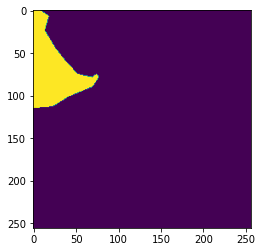

In [23]:
plt.imshow(taiga_mask[228, :,:])

In [24]:
taiga_mask[228,:,:]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

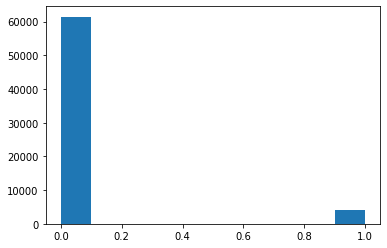

In [25]:
plt.hist(taiga_mask[228, :,:].flatten())
plt.show()

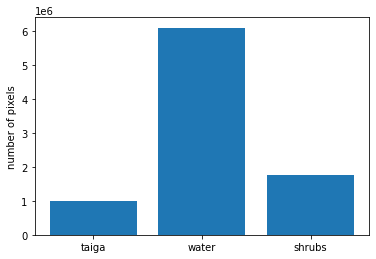

In [26]:
fig, ax = plt.subplots()
ax.bar(range(V), [taiga_mask.sum(), water_mask.sum(), shrubs_mask.sum()])
ax.set_xticks((0, 1, 2))
ax.set_xticklabels(('taiga', 'water', 'shrubs'))
plt.ylabel('number of pixels')
plt.show()

In [27]:
# organize data
W = 282
Y = np.zeros(shape=(W, N, M, V), dtype =np.int8)
Y_train_img = np.zeros(shape=(W, N, M, 1), dtype =np.float32)

Y[:, :, :, 0] = taiga_mask[:, :, :]
Y[:, :, :, 1] = water_mask[:, :, :]
Y[:, :, :, 2] = shrubs_mask[:, :, :]
Y_train_img[:, :, :, 0] = train_images_R[:, :, :, 0]




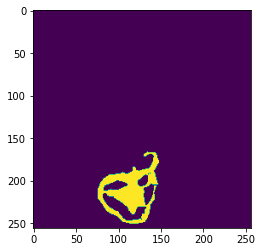

In [28]:
plt.imshow(Y[219,:,:,1])

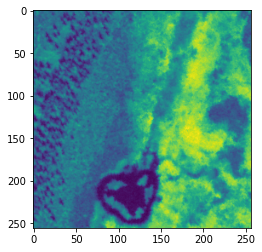

In [29]:
plt.imshow(Y_train_img[219,:,:,0])

In [31]:
Y.shape

(282, 256, 256, 3)

In [36]:
model = satellite_unet((N, M, 1), V)

In [37]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = "binary_crossentropy",
    metrics = [iou, iou_thresholded],
)

In [38]:
history = model.fit(Y_train_img, Y, epochs = 100)

Epoch 1/100
9/9 [==============================] - 42s 4s/step - loss: 0.4649 - iou: 0.2300 - iou_thresholded: 0.3223
Epoch 2/100
9/9 [==============================] - 36s 4s/step - loss: 0.2639 - iou: 0.3555 - iou_thresholded: 0.4560
Epoch 3/100
9/9 [==============================] - 36s 4s/step - loss: 0.2085 - iou: 0.4810 - iou_thresholded: 0.5606
Epoch 4/100
9/9 [==============================] - 36s 4s/step - loss: 0.1770 - iou: 0.5169 - iou_thresholded: 0.6176
Epoch 5/100
9/9 [==============================] - 36s 4s/step - loss: 0.1628 - iou: 0.5346 - iou_thresholded: 0.6463
Epoch 6/100
9/9 [==============================] - 36s 4s/step - loss: 0.1726 - iou: 0.5421 - iou_thresholded: 0.6242
Epoch 7/100
9/9 [==============================] - 36s 4s/step - loss: 0.1605 - iou: 0.5423 - iou_thresholded: 0.6487
Epoch 8/100
9/9 [==============================] - 36s 4s/step - loss: 0.1730 - iou: 0.5407 - iou_thresholded: 0.6280
Epoch 9/100
9/9 [==============================] - 36s 4

9/9 [==============================] - 36s 4s/step - loss: 0.1045 - iou: 0.7208 - iou_thresholded: 0.7868
Epoch 70/100
9/9 [==============================] - 36s 4s/step - loss: 0.0817 - iou: 0.7341 - iou_thresholded: 0.8127
Epoch 71/100
9/9 [==============================] - 36s 4s/step - loss: 0.0840 - iou: 0.7411 - iou_thresholded: 0.8146
Epoch 72/100
9/9 [==============================] - 36s 4s/step - loss: 0.0764 - iou: 0.7615 - iou_thresholded: 0.8308
Epoch 73/100
9/9 [==============================] - 36s 4s/step - loss: 0.0738 - iou: 0.7653 - iou_thresholded: 0.8344
Epoch 74/100
9/9 [==============================] - 36s 4s/step - loss: 0.0743 - iou: 0.7670 - iou_thresholded: 0.8416
Epoch 75/100
9/9 [==============================] - 36s 4s/step - loss: 0.0683 - iou: 0.7678 - iou_thresholded: 0.8454
Epoch 76/100
9/9 [==============================] - 36s 4s/step - loss: 0.0764 - iou: 0.7727 - iou_thresholded: 0.8355
Epoch 77/100
9/9 [==============================] - 36s 4s/st

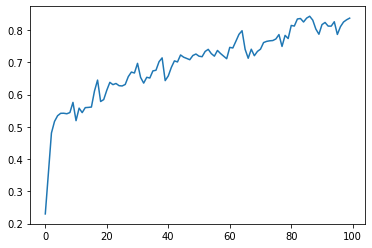

In [39]:
plt.plot(history.history['iou'])

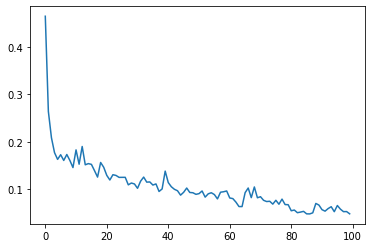

In [40]:
plt.plot(history.history['loss'])

In [41]:
modelsave_path = Path(r'/media/hkropp/research/Kolyma_Data/training/v2/model/1971_strat')

In [42]:
model.save(modelsave_path)

INFO:tensorflow:Assets written to: /media/hkropp/research/Kolyma_Data/training/v2/model/1971_strat/assets


INFO:tensorflow:Assets written to: /media/hkropp/research/Kolyma_Data/training/v2/model/1971_strat/assets


In [43]:
Y_pred = model.predict(Y_train_img)

9/9 [==============================] - 14s 2s/step


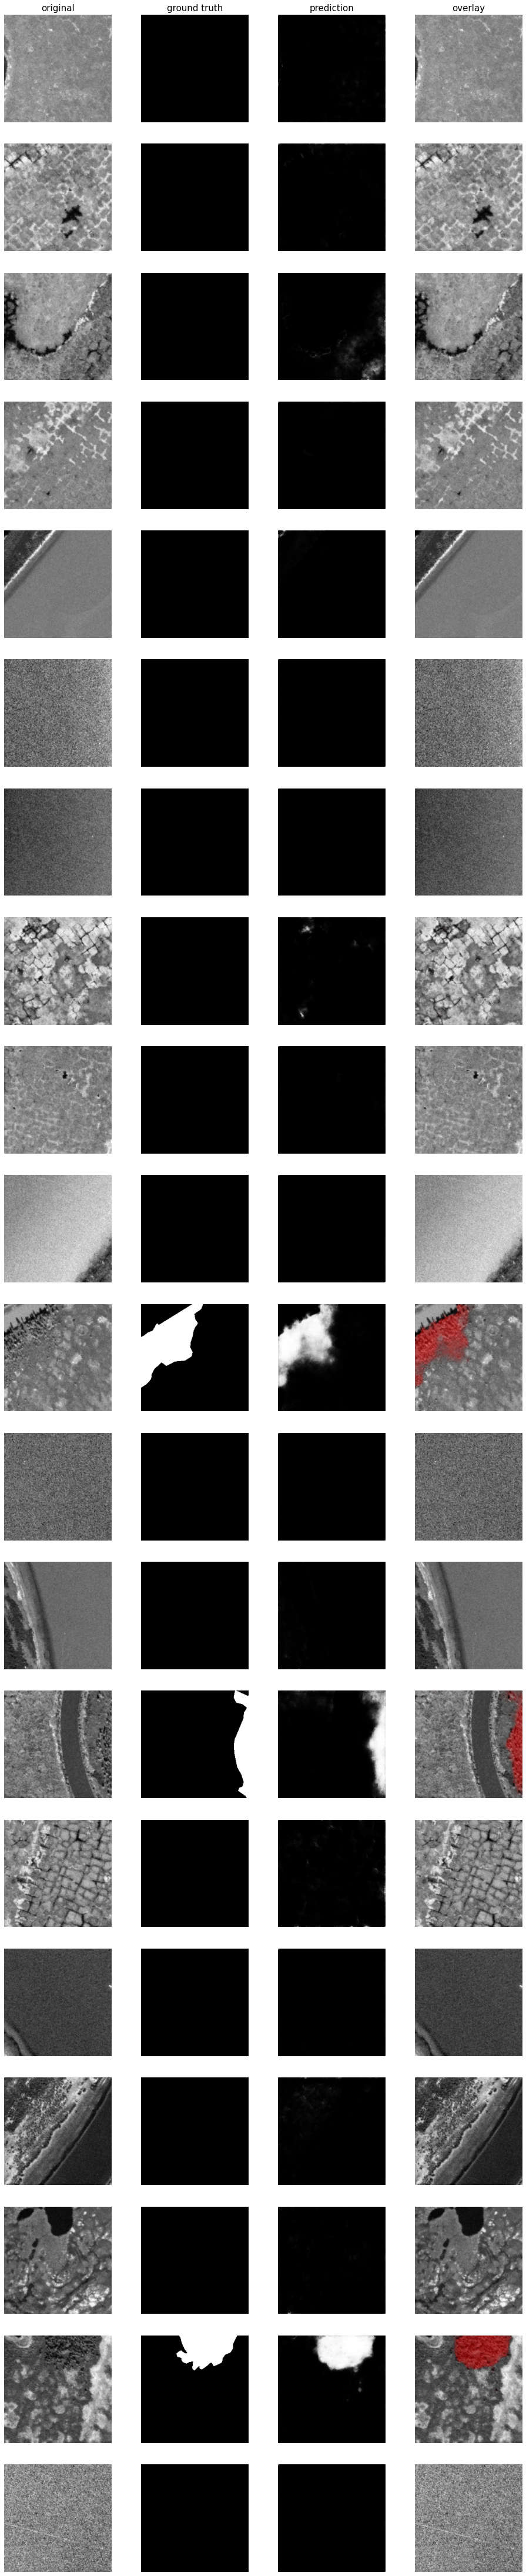

In [44]:
from keras_unet.utils import plot_imgs

# Taiga
plot_imgs(
    org_imgs=Y_train_img, 
    mask_imgs=Y[:, :, :, 0], 
    pred_imgs=Y_pred[:, :, :, 0], 
    nm_img_to_plot=20
  )

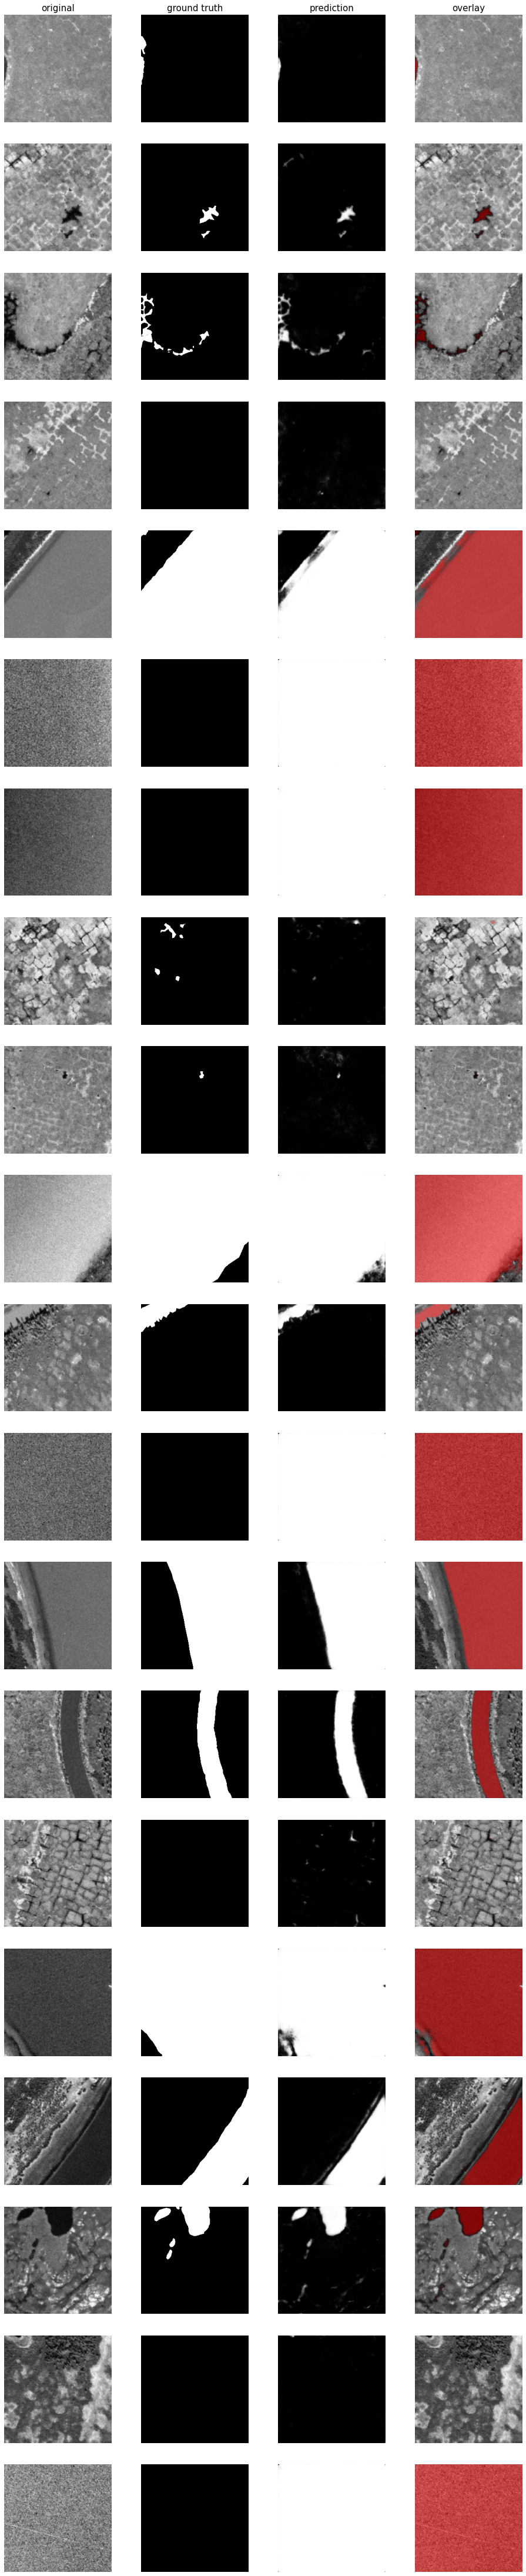

In [45]:
# Water
plot_imgs(
    org_imgs=Y_train_img, 
    mask_imgs=Y[:, :, :, 1], 
    pred_imgs=Y_pred[:, :, :, 1], 
    nm_img_to_plot=20
  )

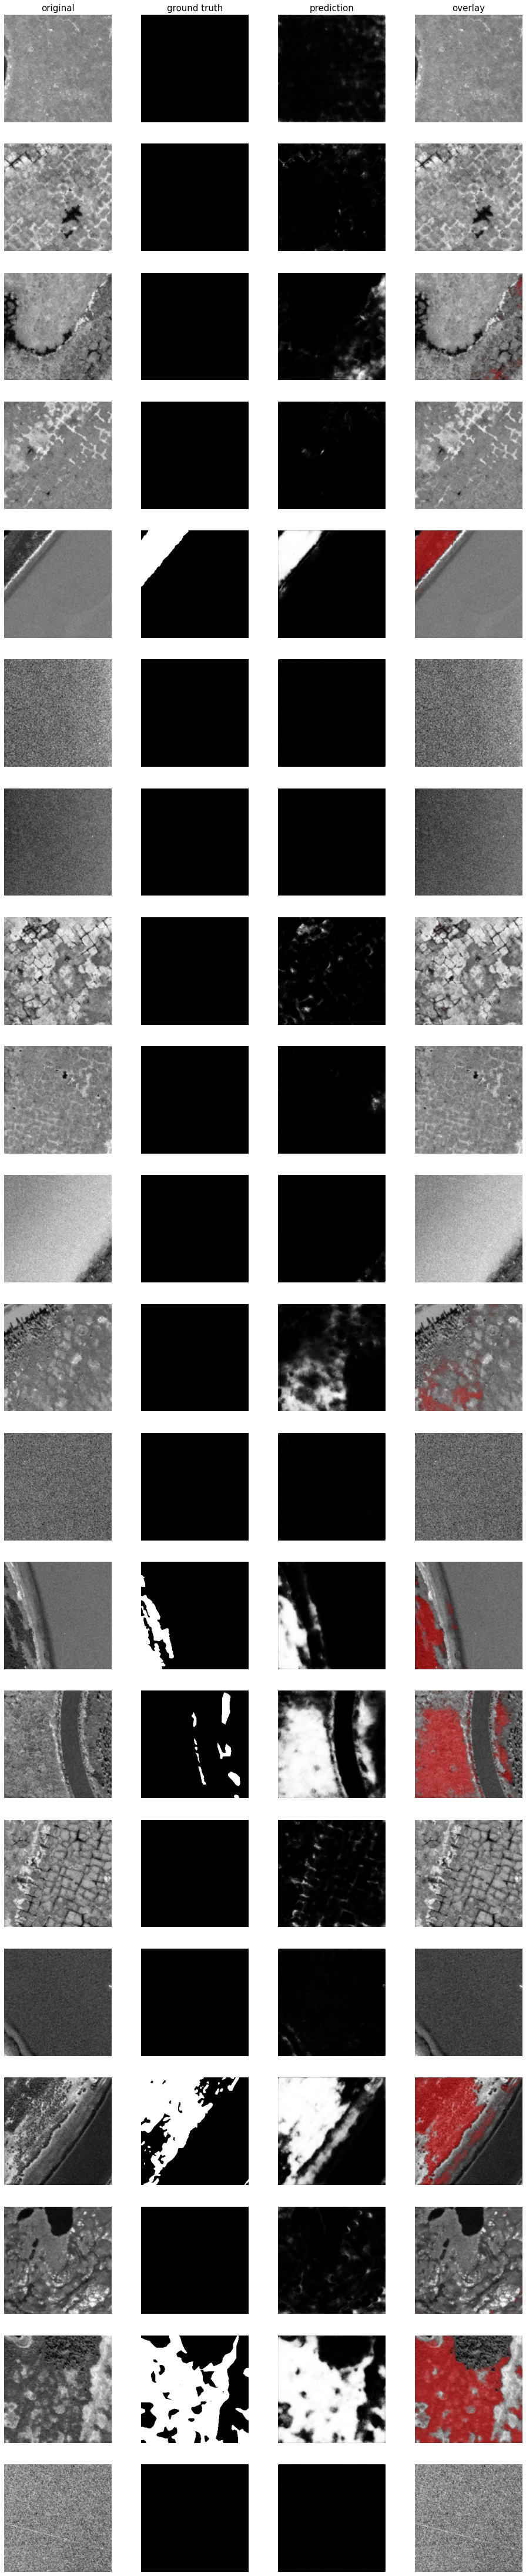

In [46]:
# Shrubs
plot_imgs(
    org_imgs=Y_train_img, 
    mask_imgs=Y[:, :, :, 2], 
    pred_imgs=Y_pred[:, :, :, 2], 
    nm_img_to_plot=20
  )

In [47]:
driver = gdal.GetDriverByName("GTiff")

In [48]:
driver.Register()

2

In [49]:
base_dirP = Path(r'/media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256')

In [50]:
tiles = os.listdir(base_dirP)

In [51]:
T = len(tiles)

In [52]:
# check for partial tiles
imgD1 = np.zeros((T,2), dtype=int)



test = load_image(r'/media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256/img1.tif')

In [53]:
for i in range(T):
    tileLoad = load_image(make_path_tile(base_dirP, "img", i + 1))
    imgD1[i,0] = tileLoad.shape[0]
    imgD1[i,1] = tileLoad.shape[1]

In [54]:
imgFlag = np.zeros((T), dtype=int)

for i in range(T):
    if imgD1[i,0] < 256 or imgD1[i,1] < 256:
        imgFlag[i] = 1
    else:
        imgFlag[i] = 0

In [55]:
imgTable = np.zeros((T,2), dtype=int)
for i in range(T):
    imgTable[i,0] = imgFlag[i]
    imgTable[i,1] = i+1

In [56]:
def load_stack_tiles(shape, dtype, img_dir, prefix, imgFlag):
    stack = np.zeros(shape = shape, dtype = dtype)
    for i in range(shape[0]):
        tilepath = make_path_tile(img_dir, prefix, i + 1)
        if imgFlag[i,0] == 1:
            print("nullified", tilepath)
            stack[i,:,:] = np.nan
        else:
            stack[i, :,:] = load_image(tilepath)
    return stack

In [57]:
predict_img = load_stack_tiles((T, N, M), np.float32,base_dirP, "img", imgTable)

nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256/img46.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256/img92.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256/img138.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256/img184.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256/img230.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256/img276.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256/img322.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256/img368.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256/img414.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256/img460.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256/img506.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256/img552.tif
nullified /media/hkropp/research/Kolyma_Da

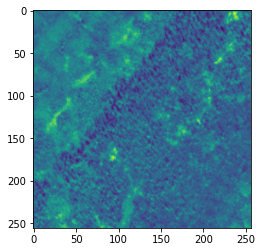

In [58]:
plt.imshow(predict_img[1000,:,:])

In [59]:
predict_img[3000,:,:]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [60]:
Y_all = model.predict(predict_img.reshape(T, N, M, 1))

95/95 [==============================] - 148s 2s/step


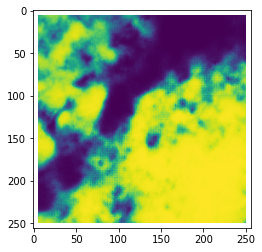

In [61]:
# change edges to missing data
Y_trim = Y_all
Y_trim[:,0:5,:,:] = np.nan
Y_trim[:,:,0:5,:] = np.nan
Y_trim[:,251:256,:,:] = np.nan
Y_trim[:,:,251:256,:] = np.nan
plt.imshow(Y_trim[1000,:,:,2])

In [62]:
def save_predict_taiga( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(T):
        image_path = make_path(img_dir, prefix, i + 1)
        tilepath = make_path_tile(orig_dir, prefix_orig, i + 1)
        orig_ds = gdal.Open(tilepath)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_trim[i, :, :, 0])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [63]:
taiga_valid_dir = r'/media/hkropp/research/Kolyma_Data/predictions/v2/1971/taiga'
save_predict_taiga(nImg = T,xdim= 256, ydim= 256,img_dir = taiga_valid_dir,prefix = "taiga_predict",orig_dir = base_dirP , prefix_orig = "img")

In [64]:
def save_predict_water( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(T):
        image_path = make_path(img_dir, prefix, i + 1)
        tilepath = make_path_tile(orig_dir, prefix_orig, i + 1)
        orig_ds = gdal.Open(tilepath)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_trim[i, :, :, 1])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [65]:
water_valid_dir = r'/media/hkropp/research/Kolyma_Data/predictions/v2/1971/water'
save_predict_water(nImg = T,xdim= 256, ydim= 256,img_dir = water_valid_dir,prefix = "water_predict",orig_dir = base_dirP , prefix_orig = "img")

In [66]:
def save_predict_shrub( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(T):
        image_path = make_path(img_dir, prefix, i + 1)
        tilepath = make_path_tile(orig_dir, prefix_orig, i + 1)
        orig_ds = gdal.Open(tilepath)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_trim[i, :, :, 2])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [67]:
shrub_valid_dir = r'/media/hkropp/research/Kolyma_Data/predictions/v2/1971/shrub'
save_predict_shrub(nImg = T,xdim= 256, ydim= 256,img_dir = shrub_valid_dir,prefix = "shrub_predict",orig_dir = base_dirP , prefix_orig = "img")

In [68]:
base_dirP2 = Path(r'/media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_2')

tiles = os.listdir(base_dirP2)

T = len(tiles)

# check for partial tiles
imgD1 = np.zeros((T,2), dtype=int)



test = load_image(r'/media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_2/img1.tif')

for i in range(T):
    tileLoad = load_image(make_path_tile(base_dirP2, "img", i + 1))
    imgD1[i,0] = tileLoad.shape[0]
    imgD1[i,1] = tileLoad.shape[1]

imgFlag = np.zeros((T), dtype=int)

for i in range(T):
    if imgD1[i,0] < 256 or imgD1[i,1] < 256:
        imgFlag[i] = 1
    else:
        imgFlag[i] = 0

imgTable = np.zeros((T,2), dtype=int)
for i in range(T):
    imgTable[i,0] = imgFlag[i]
    imgTable[i,1] = i+1

def load_stack_tiles(shape, dtype, img_dir, prefix, imgFlag):
    stack = np.zeros(shape = shape, dtype = dtype)
    for i in range(shape[0]):
        tilepath = make_path_tile(img_dir, prefix, i + 1)
        if imgFlag[i,0] == 1:
            print("nullified", tilepath)
            stack[i,:,:] = np.nan
        else:
            stack[i, :,:] = load_image(tilepath)
    return stack

In [69]:
predict_img_2 = load_stack_tiles((T, N, M), np.float32,base_dirP2, "img", imgTable)

nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_2/img46.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_2/img92.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_2/img138.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_2/img184.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_2/img230.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_2/img276.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_2/img322.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_2/img368.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_2/img414.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_2/img460.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_2/img506.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_2/img552.tif
nullified /media/h

In [70]:
Y_all2 = model.predict(predict_img_2.reshape(T, N, M, 1))

95/95 [==============================] - 147s 2s/step


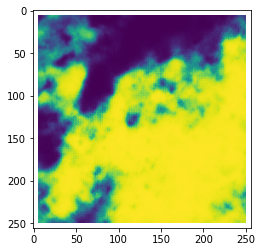

In [71]:
# change edges to missing data
Y_trim2 = Y_all2
Y_trim2[:,0:5,:,:] = np.nan
Y_trim2[:,:,0:5,:] = np.nan
Y_trim2[:,251:256,:,:] = np.nan
Y_trim2[:,:,251:256,:] = np.nan
plt.imshow(Y_trim2[1000,:,:,2])

In [72]:
def save_predict_taiga2( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(T):
        image_path = make_path(img_dir, prefix, i + 1)
        tilepath = make_path_tile(orig_dir, prefix_orig, i + 1)
        orig_ds = gdal.Open(tilepath)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_trim2[i, :, :, 0])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [73]:
taiga_valid_dir = r'/media/hkropp/research/Kolyma_Data/predictions/v2/1971_2/taiga'
save_predict_taiga2(nImg = T,xdim= 256, ydim= 256,img_dir = taiga_valid_dir,prefix = "taiga_predict",orig_dir = base_dirP2 , prefix_orig = "img")

In [74]:
def save_predict_water2( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(T):
        image_path = make_path(img_dir, prefix, i + 1)
        tilepath = make_path_tile(orig_dir, prefix_orig, i + 1)
        orig_ds = gdal.Open(tilepath)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_trim2[i, :, :, 1])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [75]:
water_valid_dir = r'/media/hkropp/research/Kolyma_Data/predictions/v2/1971_2/water'
save_predict_water2(nImg = T,xdim= 256, ydim= 256,img_dir = water_valid_dir,prefix = "water_predict",orig_dir = base_dirP2 , prefix_orig = "img")

In [76]:
def save_predict_shrub2( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(T):
        image_path = make_path(img_dir, prefix, i + 1)
        tilepath = make_path_tile(orig_dir, prefix_orig, i + 1)
        orig_ds = gdal.Open(tilepath)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_trim2[i, :, :, 2])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [77]:
shrub_valid_dir = r'/media/hkropp/research/Kolyma_Data/predictions/v2/1971_2/shrub'
save_predict_shrub2(nImg = T,xdim= 256, ydim= 256,img_dir = shrub_valid_dir,prefix = "shrub_predict",orig_dir = base_dirP2 , prefix_orig = "img")

In [78]:
base_dirP3 = Path(r'/media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_3')

tiles = os.listdir(base_dirP3)

T = len(tiles)

# check for partial tiles
imgD1 = np.zeros((T,2), dtype=int)



test = load_image(r'/media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_3/img1.tif')

for i in range(T):
    tileLoad = load_image(make_path_tile(base_dirP3, "img", i + 1))
    imgD1[i,0] = tileLoad.shape[0]
    imgD1[i,1] = tileLoad.shape[1]

imgFlag = np.zeros((T), dtype=int)

for i in range(T):
    if imgD1[i,0] < 256 or imgD1[i,1] < 256:
        imgFlag[i] = 1
    else:
        imgFlag[i] = 0

imgTable = np.zeros((T,2), dtype=int)
for i in range(T):
    imgTable[i,0] = imgFlag[i]
    imgTable[i,1] = i+1

def load_stack_tiles(shape, dtype, img_dir, prefix, imgFlag):
    stack = np.zeros(shape = shape, dtype = dtype)
    for i in range(shape[0]):
        tilepath = make_path_tile(img_dir, prefix, i + 1)
        if imgFlag[i,0] == 1:
            print("nullified", tilepath)
            stack[i,:,:] = np.nan
        else:
            stack[i, :,:] = load_image(tilepath)
    return stack

In [79]:
predict_img_3 = load_stack_tiles((T, N, M), np.float32,base_dirP3, "img", imgTable)

nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_3/img46.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_3/img92.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_3/img138.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_3/img184.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_3/img230.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_3/img276.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_3/img322.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_3/img368.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_3/img414.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_3/img460.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_3/img506.tif
nullified /media/hkropp/research/Kolyma_Data/img_tiles/1971e/img_256_3/img552.tif
nullified /media/h

In [80]:
Y_all3 = model.predict(predict_img_3.reshape(T, N, M, 1))

95/95 [==============================] - 148s 2s/step


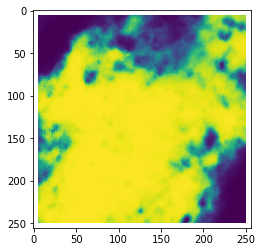

In [81]:
# change edges to missing data
Y_trim3 = Y_all3
Y_trim3[:,0:5,:,:] = np.nan
Y_trim3[:,:,0:5,:] = np.nan
Y_trim3[:,251:256,:,:] = np.nan
Y_trim3[:,:,251:256,:] = np.nan
plt.imshow(Y_trim3[1000,:,:,2])

In [82]:
def save_predict_taiga3( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(T):
        image_path = make_path(img_dir, prefix, i + 1)
        tilepath = make_path_tile(orig_dir, prefix_orig, i + 1)
        orig_ds = gdal.Open(tilepath)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_trim3[i, :, :, 0])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [83]:
taiga_valid_dir = r'/media/hkropp/research/Kolyma_Data/predictions/v2/1971_3/taiga'
save_predict_taiga3(nImg = T,xdim= 256, ydim= 256,img_dir = taiga_valid_dir,prefix = "taiga_predict",orig_dir = base_dirP3 , prefix_orig = "img")

In [84]:
def save_predict_water3( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(T):
        image_path = make_path(img_dir, prefix, i + 1)
        tilepath = make_path_tile(orig_dir, prefix_orig, i + 1)
        orig_ds = gdal.Open(tilepath)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_trim3[i, :, :, 1])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [85]:
water_valid_dir = r'/media/hkropp/research/Kolyma_Data/predictions/v2/1971_3/water'
save_predict_water3(nImg = T,xdim= 256, ydim= 256,img_dir = water_valid_dir,prefix = "water_predict",orig_dir = base_dirP3 , prefix_orig = "img")

In [86]:
def save_predict_shrub3( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(T):
        image_path = make_path(img_dir, prefix, i + 1)
        tilepath = make_path_tile(orig_dir, prefix_orig, i + 1)
        orig_ds = gdal.Open(tilepath)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_trim3[i, :, :, 2])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [87]:
shrub_valid_dir = r'/media/hkropp/research/Kolyma_Data/predictions/v2/1971_3/shrub'
save_predict_shrub3(nImg = T,xdim= 256, ydim= 256,img_dir = shrub_valid_dir,prefix = "shrub_predict",orig_dir = base_dirP3 , prefix_orig = "img")